Coupling map:


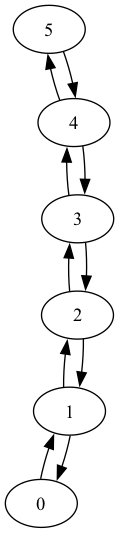

In [1]:
from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = ParameterVector("θ", num_qubits)
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

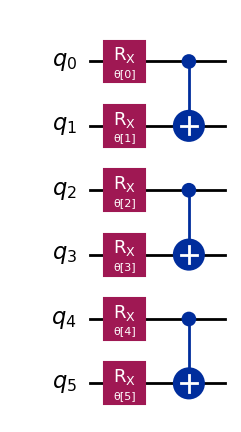

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {ParameterVectorElement(θ[0]): 4.665466064857704, ParameterVectorElement(θ[1]): 3.4958331672967256, ParameterVectorElement(θ[2]): 1.1607433119572852, ParameterVectorElement(θ[3]): 3.9246618340416872, ParameterVectorElement(θ[4]): 0.8148633976847353, ParameterVectorElement(θ[5]): 6.110646020345377}


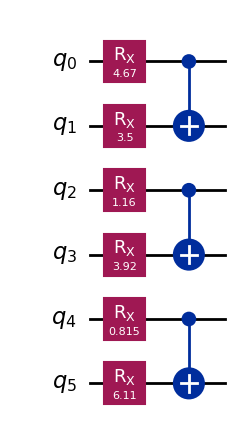

In [3]:
seed = 20983
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

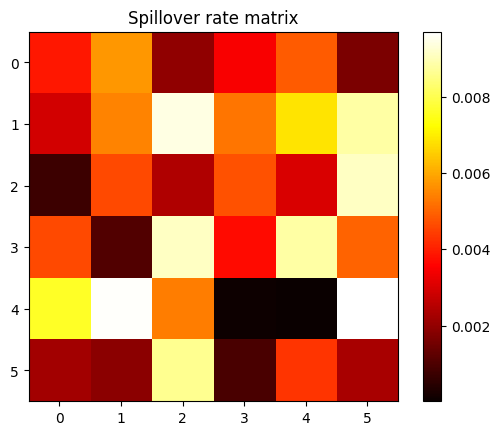

In [4]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.05  # γ_0->1
gamma_matrix[0, 3] = 0.0  # γ_0->3
gamma_matrix[1, 2] = 0.05  # γ_1->2
gamma_matrix[2, 2] = 0.05  # γ_2->2
gamma_matrix[2, 3] = 0.05  # γ_2->3
gamma_matrix[3, 2] = 0.05  # γ_3->2
gamma_matrix[4, 3] = 0.0  # γ_4->3
gamma_matrix[5, 4] = 0.0  # γ_5->4
gamma_matrix = 0.01 * np.round(np.random.rand(num_qubits, num_qubits), 3)
# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [5]:
gamma_matrix

array([[3.91e-03, 5.75e-03, 1.98e-03, 3.49e-03, 4.88e-03, 1.65e-03],
       [2.92e-03, 5.43e-03, 9.42e-03, 5.25e-03, 6.83e-03, 8.81e-03],
       [7.50e-04, 4.60e-03, 2.41e-03, 4.74e-03, 3.02e-03, 9.10e-03],
       [4.60e-03, 1.06e-03, 9.13e-03, 3.69e-03, 8.82e-03, 4.99e-03],
       [7.62e-03, 9.64e-03, 5.36e-03, 9.00e-05, 2.00e-05, 9.70e-03],
       [2.23e-03, 1.88e-03, 8.62e-03, 9.40e-04, 4.33e-03, 2.29e-03]])

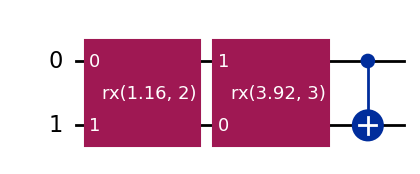

In [6]:
pm = PassManager(
    [
        LocalSpilloverNoiseAerPass(
            spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
            target_subsystem=(2, 3),
        )
    ]
)
qc_noisy = pm.run(circuit.assign_parameters(param_dict))
qc_noisy.draw("mpl")

In [7]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [8]:
backend.operation_names

['roerror',
 'save_amplitudes_sq',
 'save_matrix_product_state',
 'set_statevector',
 'unitary',
 'initialize',
 'if_else',
 'rzx',
 'save_probabilities',
 'kraus',
 'for_loop',
 'save_statevector_dict',
 'continue_loop',
 'save_probabilities_dict',
 'save_clifford',
 'save_superop',
 'cx',
 'x',
 'save_stabilizer',
 'z',
 'h',
 'rz',
 'save_statevector',
 'delay',
 'superop',
 'save_amplitudes',
 'set_matrix_product_state',
 'set_superop',
 'while_loop',
 'break_loop',
 'rx',
 'qerror_loc',
 'switch_case',
 'measure',
 'save_expval_var',
 'u',
 'save_density_matrix',
 'save_unitary',
 'save_expval',
 'set_density_matrix',
 'save_state',
 's',
 'reset',
 'set_stabilizer',
 'set_unitary',
 'quantum_channel',
 'ry']

In [9]:
print("Rotation angles:", rotation_angles)

Rotation angles: [4.66546606 3.49583317 1.16074331 3.92466183 0.8148634  6.11064602]


In [10]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '0498015cf61d4cd6a1d685dc77c4453a',
   'operations': ['rx(1.16, 2)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[0.99762598+0.j        , 0.        -0.06886513j,
               0.        +0.j        , 0.        +0.j        ],
              [0.        -0.06886513j, 0.99762598+0.j        ,
               0.        +0.j        , 0.        +0.j        ],
              [0.        +0.j        , 0.        +0.j        ,
               0.99762598+0.j        , 0.        -0.06886513j],
              [0.        +0.j        , 0.        +0.j        ,
               0.        -0.06886513j, 0.99762598+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(0, 1)]},
  {'type': 'qerror',
   'id': 'f00b5b450dfd4c4e8d3f12766ec5336b',
   'operations': ['rx(3.92, 3)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[0.99954346+0.j        , 0.        +0.j        ,
       

In [11]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))


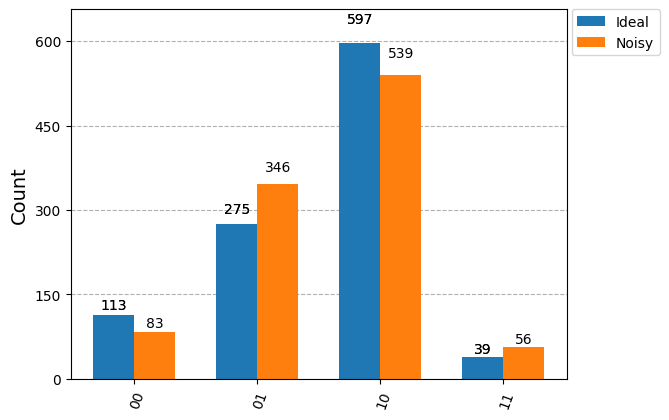

In [12]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [13]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [14]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9921630325101866

In [15]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        *new_params[:3],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}
action_space = Box(low=-1.0, high=1.0, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [0, 1]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=None,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[3, 6, 9, 12],
        n_shots=100,
        sampling_paulis=200,
        c_factor=1,
        seed=seed+6,
    ),
    reward_config="channel",
    env_metadata=env_metadata,
)
q_env = ContextAwareQuantumEnvironment(
    q_env_config,
    circuit_context=qc_noisy,  # Pass the circuit already transpiled through custom pass
)

In [17]:
rescaled_env = RescaleAndClipAction(q_env, -1, 1)

In [25]:
print(np.linspace(1, 101, 21, dtype=np.int8))

[  1   6  11  16  21  26  31  36  41  46  51  56  61  66  71  76  81  86
  91  96 101]


Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9848040195474637
Sending Estimator job...
Time for running 0.2279820442199707 seconds
Finished Estimator job
Reward (avg): 0.6958476934046862 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9848040195474637
Sending Estimator job...
Time for running 0.3335897922515869 seconds
Finished Estimator job
Reward (avg): 0.44103240748184214 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9848040195474637
Sending Estimator job...
Time for running 0.41402697563171387 seconds
Finished Estimator job
Reward (avg): 0.5496637471547868 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9848040195474637
Sending Estimator job...
Time for running 0.46210718154907227 seconds
Finished Estimator job
Reward (avg): 0.5410621097893542 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fideliti

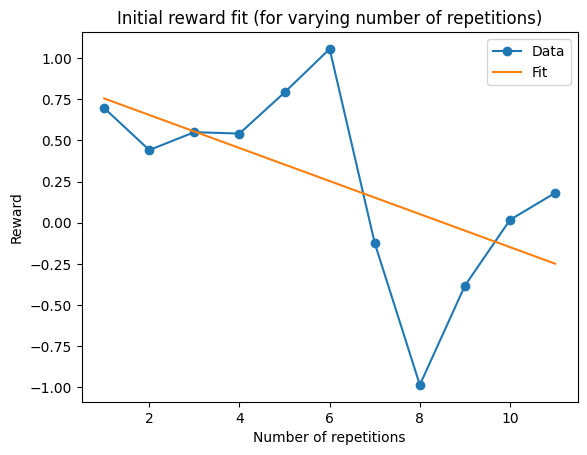

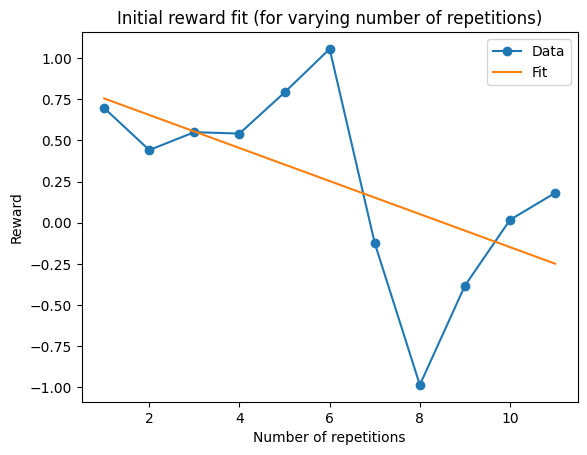

In [28]:
q_env.initial_reward_fit(
    np.zeros((1, 7)),
    ExecutionConfig(
        sampling_paulis=10000,
        n_shots=1000,
        #n_reps=list(
        #    range(1, 100),
        #),
        n_reps=np.linspace(1, 11, 11, dtype=np.int8),
        dfe_precision=(1e-1, 0.1),
        seed=q_env_config.seed,
    ),
    update_fit_params=False,
    reward_method="channel",
)

In [33]:
# Replicating nreps behaviour

n_reps = np.linspace(1, 11, 11, dtype=np.int8)

execution_config = ExecutionConfig(
    sampling_paulis=10000,
    n_shots=1000,
    #n_reps=list(
    #    range(1, 100),
    #),
    n_reps=n_reps,
    dfe_precision=(1e-1, 0.1),
    seed=q_env_config.seed,
)

reward_method = 'channel'
params = np.zeros((1, 7))

initial_execution_config = q_env.config.execution_config
initial_reward_method = q_env.config.reward_method
q_env.config.execution_config = execution_config
q_env.config.reward_method = reward_method
reward_data = []
for i in range(len(q_env.config.execution_config.n_reps)):
    q_env.config.execution_config.n_reps_index = i
    reward = q_env.perform_action(params, update_env_history=False)
    reward_data.append(np.mean(reward))

q_env.config.execution_config = initial_execution_config
q_env.config.reward_method = initial_reward_method

Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9848040195474637
Sending Estimator job...
Time for running 0.2645070552825928 seconds
Finished Estimator job
Reward (avg): 0.7080882571584225 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9848040195474637
Sending Estimator job...
Time for running 0.4063529968261719 seconds
Finished Estimator job
Reward (avg): 0.4501413926352071 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9848040195474637
Sending Estimator job...
Time for running 0.5374460220336914 seconds
Finished Estimator job
Reward (avg): 0.55710567561587 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9848040195474637
Sending Estimator job...
Time for running 0.5419130325317383 seconds
Finished Estimator job
Reward (avg): 0.5369724492035984 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  

In [38]:
q_env.config.dfe

True

In [34]:
print(reward_data)

[0.7080882571584225, 0.4501413926352071, 0.55710567561587, 0.5369724492035984, 0.7892095131807693, 1.0406976157394476, -0.13520976162653994, -0.9713559536614726, -0.3779087032126369, 0.0210600180546036, 0.17677062266744123]


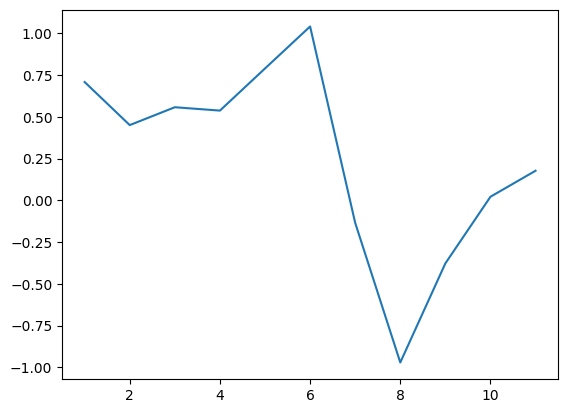

In [35]:
plt.plot(np.linspace(1, 11, 11, dtype=np.int8), reward_data)
plt.show()

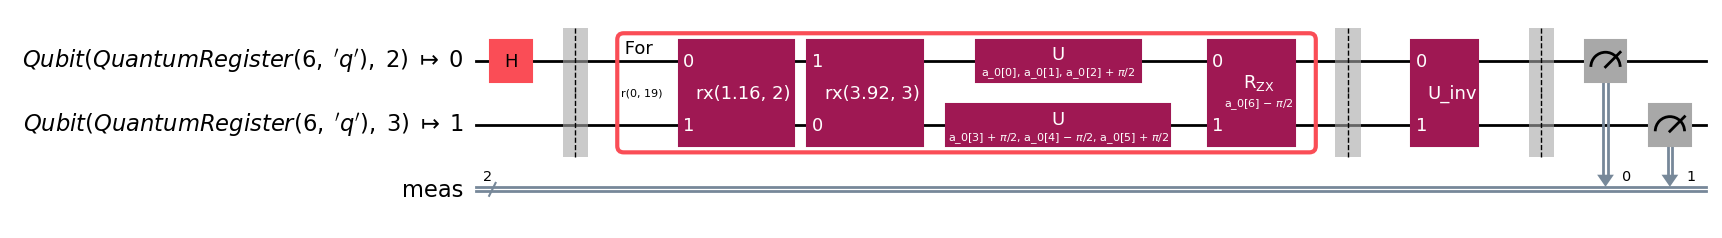

In [19]:
q_env.pubs[8].circuit.draw("mpl")

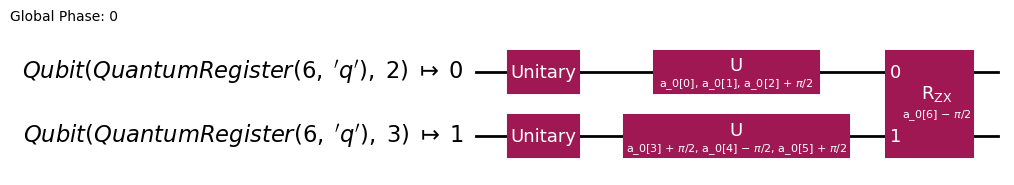

In [20]:
q_env.backend_info.custom_transpile(q_env.circuits[0]).draw("mpl")

In [21]:
from rl_qoc.agent import PPOConfig

agent_config = PPOConfig.from_yaml("agent_config.yaml")
print(agent_config)

PPOConfig(run_name='spillover_subsystem', num_updates=1, n_epochs=8, learning_rate=0.0005, gamma=0.99, gae_lambda=0.95, clip_ratio=0.2, clip_value_loss=True, clip_value_coef=0.2, normalize_advantage=True, entropy_coef=0.01, value_loss_coef=0.5, gradient_clip=0.5, include_critic=True, hidden_layers=[64, 64], hidden_activation_functions=[Tanh(), Tanh()], input_activation_function=Identity(), output_activation_mean=Tanh(), output_activation_std=Sigmoid(), optimizer=<class 'torch.optim.adam.Adam'>, minibatch_size=16, checkpoint_dir='tmp/ppo', training_config=TrainingConfig(training_constraint=TotalUpdates(total_updates=250), target_fidelities=[0.999, 0.9999, 0.99999], lookback_window=10, anneal_learning_rate=False, std_actions_eps=0.01), train_function_settings=TrainFunctionSettings(plot_real_time=False, print_debug=False, num_prints=10, hpo_mode=False, clear_history=False, save_data=False), wandb_config=WandBConfig(enabled=True, project='GateCalibration', entity=None, tags=None, notes=Non

In [22]:
from rl_qoc.agent import CustomPPO, TrainingConfig, TrainFunctionSettings, TotalUpdates

ppo_agent = CustomPPO(agent_config, rescaled_env, save_data=False)
total_updates = 500
target_fidelities = [0.999]
lookback_window = 20
anneal_learning_rate = True

ppo_config = TrainingConfig(
    TotalUpdates(total_updates),
    target_fidelities,
    lookback_window,
    anneal_learning_rate,
)
train_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=False,
    num_prints=10,
    hpo_mode=False,
    clear_history=True,
)

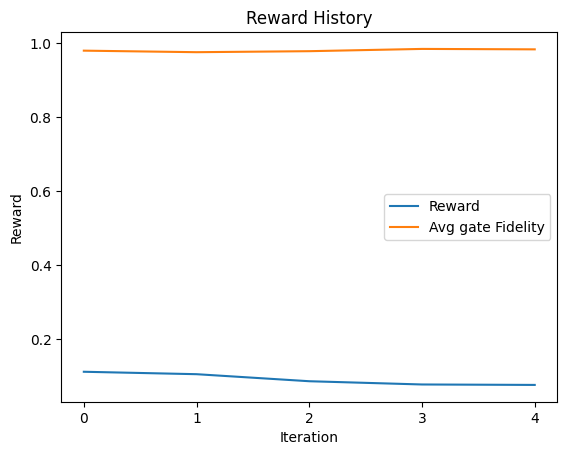


 Number of repetitions: 3
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9848040195474637
Sending Estimator job...


{'avg_reward': [0.11234607158823932,
  0.1057664083939573,
  0.08675753279839352,
  0.07798500817658308,
  0.076787708009293],
 'fidelity_history': [0.9797587489271461,
  0.9756021046080814,
  0.9783210297147065,
  0.9844328994654798,
  0.9832737731360343],
 'hardware_runtime': [],
 'total_shots': [832640, 896768, 896768, 832640, 896768],
 'total_updates': [],
 'clipped_mean_action_0': [tensor(0.0296),
  tensor(0.0226),
  tensor(-0.0124),
  tensor(-0.0450),
  tensor(-0.0427)],
 'mean_action_0': [tensor(0.0296),
  tensor(0.0226),
  tensor(-0.0124),
  tensor(-0.0450),
  tensor(-0.0427)],
 'std_action_0': [tensor(0.5101),
  tensor(0.5030),
  tensor(0.4992),
  tensor(0.4942),
  tensor(0.4855)],
 'clipped_mean_action_1': [tensor(0.0172),
  tensor(-0.0337),
  tensor(-0.0406),
  tensor(-0.0097),
  tensor(0.0192)],
 'mean_action_1': [tensor(0.0172),
  tensor(-0.0337),
  tensor(-0.0406),
  tensor(-0.0097),
  tensor(0.0192)],
 'std_action_1': [tensor(0.4775),
  tensor(0.4779),
  tensor(0.4745),


<Figure size 640x480 with 0 Axes>

In [23]:
%matplotlib inline
ppo_agent.train(ppo_config, train_settings)

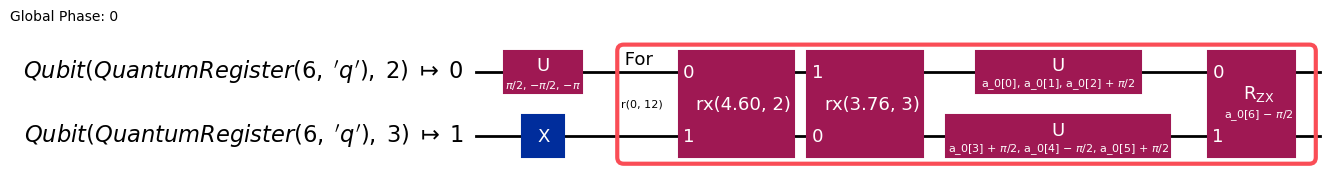

In [ ]:
q_env.pubs[10].circuit.draw("mpl")

In [ ]:
from qiskit.qasm3 import dumps as qasm3_dumps

print(
    qasm3_dumps(
        circuit_context(
            num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
        ).measure_all(False)
    )
)

OPENQASM 3.0;
include "stdgates.inc";
input float[64] _θ_0_;
input float[64] _θ_1_;
input float[64] _θ_2_;
input float[64] _θ_3_;
input float[64] _θ_4_;
input float[64] _θ_5_;
bit[6] meas;
qubit[6] q;
rx(_θ_0_) q[0];
rx(_θ_1_) q[1];
rx(_θ_2_) q[2];
rx(_θ_3_) q[3];
rx(_θ_4_) q[4];
rx(_θ_5_) q[5];
cx q[0], q[1];
cx q[2], q[3];
cx q[4], q[5];
barrier q[0], q[1], q[2], q[3], q[4], q[5];
meas[0] = measure q[0];
meas[1] = measure q[1];
meas[2] = measure q[2];
meas[3] = measure q[3];
meas[4] = measure q[4];
meas[5] = measure q[5];



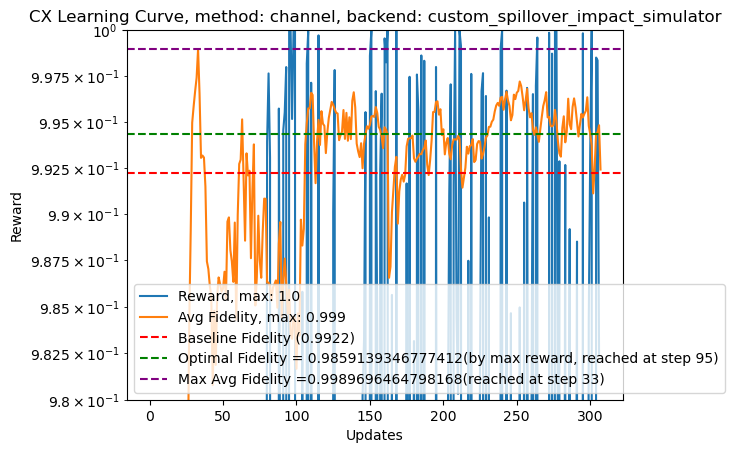

In [ ]:
# Plotting the learning curve
import matplotlib.pyplot as plt

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = np.round(np.max(mean_rewards), 4)
arg_max_mean = np.argmax(mean_rewards)
baseline_fidelity = np.round(
    q_env.simulate_circuit(
        q_env.circuits[0],
        np.zeros((1, q_env.action_space.shape[-1])),
        update_env_history=False,
    ),
    4,
)[0]

plot_reward = True
plot_fidelity = True
plot_circuit_fidelity = False
plot_fidelity_nreps = False
plot_circuit_fidelity_nreps = False

if plot_reward:
    plt.plot(mean_rewards, label=f"Reward, max: {max_mean}")
if plot_fidelity:
    plt.plot(
        q_env.fidelity_history,
        label=f"Avg Fidelity, max: {np.round(np.max(q_env.fidelity_history),4)}",
    )
if plot_circuit_fidelity_nreps:
    plt.plot(
        q_env.circuit_fidelity_history_nreps,
        label=f"Circuit Fidelity nreps(={q_env.n_reps})",
    )
if plot_fidelity_nreps:
    plt.plot(
        q_env.avg_fidelity_history_nreps, label=f"Avg Fidelity nreps(={q_env.n_reps})"
    )
if plot_circuit_fidelity:
    plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.axhline(
    baseline_fidelity,
    label=f"Baseline Fidelity ({baseline_fidelity})",
    color="red",
    linestyle="--",
)
plt.axhline(
    q_env.simulate_circuit(
        q_env.circuits[0], np.array([q_env.optimal_action]), update_env_history=False
    ),
    label=f"Optimal Fidelity = {q_env.fidelity_history[arg_max_mean]}(by max reward, reached at step {arg_max_mean})",
    color="green",
    linestyle="--",
)
plt.axhline(
    np.max(q_env.fidelity_history),
    label=f"Max Avg Fidelity ={np.max(q_env.fidelity_history)}(reached at step {np.argmax(q_env.fidelity_history)})",
    color="purple",
    linestyle="--",
)
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env.config.backend.name if q_env.config.backend is not None else 'No backend'}"
)
plt.ylim(0.98, 1.00001)
plt.yscale("log")
plt.legend()

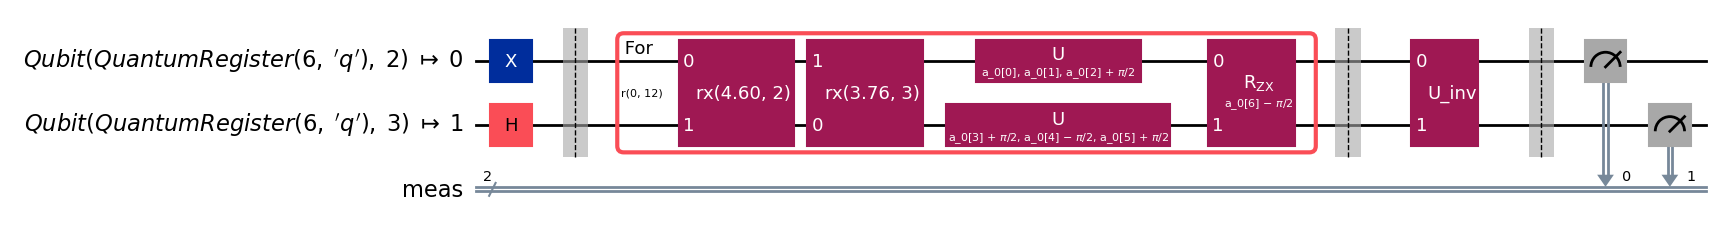

In [ ]:
from qiskit.qasm3 import dumps as qasm3_dumps

circuit = q_env.pubs[6].circuit
circuit.draw("mpl")

In [ ]:
print(qasm3_dumps(circuit))

OPENQASM 3.0;
include "stdgates.inc";
input float[64] _a_0_0_;
input float[64] _a_0_1_;
input float[64] _a_0_2_;
input float[64] _a_0_3_;
input float[64] _a_0_4_;
input float[64] _a_0_5_;
input float[64] _a_0_6_;
gate unitary _gate_q_0, _gate_q_1 {
  U(1.6839317270456968, pi/2, -pi/2) _gate_q_0;
  U(0, pi/2, -pi/2) _gate_q_1;
}
gate unitary_0 _gate_q_0, _gate_q_1 {
  U(2.521703115254364, pi/2, -pi/2) _gate_q_0;
  U(0, pi/2, -pi/2) _gate_q_1;
}
gate rzx(p0) _gate_q_0, _gate_q_1 {
  h _gate_q_1;
  cx _gate_q_0, _gate_q_1;
  rz(p0) _gate_q_1;
  cx _gate_q_0, _gate_q_1;
  h _gate_q_1;
}
gate unitary_1 _gate_q_0, _gate_q_1 {
  U(pi/2, -0.6301354407285, -pi) _gate_q_0;
  U(1.4803216829759538, 1.1067350876626492, 0.04519156587644968) _gate_q_1;
  cx _gate_q_0, _gate_q_1;
  U(pi, 0.004205296856392593, 1.5750016236512892) _gate_q_0;
  U(1.548533699585029, 1.5073650420650146, -2.2456941554049172) _gate_q_1;
  cx _gate_q_0, _gate_q_1;
  U(pi/2, -pi, -2.8797441690281973) _gate_q_0;
  U(1.469690626

In [ ]:
q_env._pauli_shots

In [ ]:
len(np.nonzero(np.round(q_env.target.Chi, 5))[0])

TypeError: unsupported operand type(s) for *: 'method' and 'float'

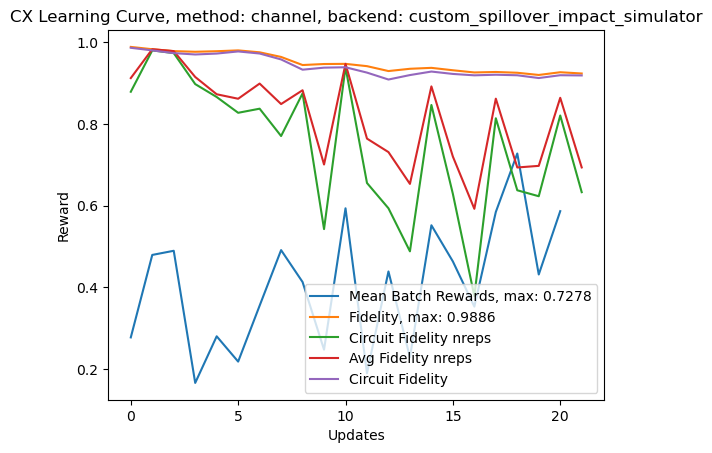

In [ ]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
)
plt.plot(q_env.circuit_fidelity_history_nreps, label="Circuit Fidelity nreps")
plt.plot(q_env.avg_fidelity_history_nreps, label="Avg Fidelity nreps")
plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.legend()
plt.show()

In [ ]:
q_env.optimal_action

array([-0.49803594,  0.24635266, -0.3534245 , -0.47022524, -0.12757206,
       -0.0193499 , -0.22986718], dtype=float32)

In [ ]:
q_env.optimal_action

array([-0.49803594,  0.24635266, -0.3534245 , -0.47022524, -0.12757206,
       -0.0193499 , -0.22986718], dtype=float32)

In [ ]:
q_env.backend.operation_names

['reset',
 'delay',
 'kraus',
 'rx',
 'qerror_loc',
 'save_unitary',
 'set_stabilizer',
 'ry',
 'set_statevector',
 'save_statevector',
 'save_probabilities_dict',
 'save_statevector_dict',
 'x',
 'for_loop',
 'if_else',
 'save_amplitudes_sq',
 'save_expval',
 'save_probabilities',
 'quantum_channel',
 'measure',
 'save_density_matrix',
 'switch_case',
 's',
 'z',
 'while_loop',
 'u',
 'unitary',
 'rzx',
 'save_superop',
 'rz',
 'set_unitary',
 'save_matrix_product_state',
 'save_clifford',
 'save_expval_var',
 'set_density_matrix',
 'initialize',
 'save_amplitudes',
 'set_matrix_product_state',
 'superop',
 'save_stabilizer',
 'cx',
 'h',
 'save_state',
 'break_loop',
 'set_superop',
 'roerror',
 'continue_loop']

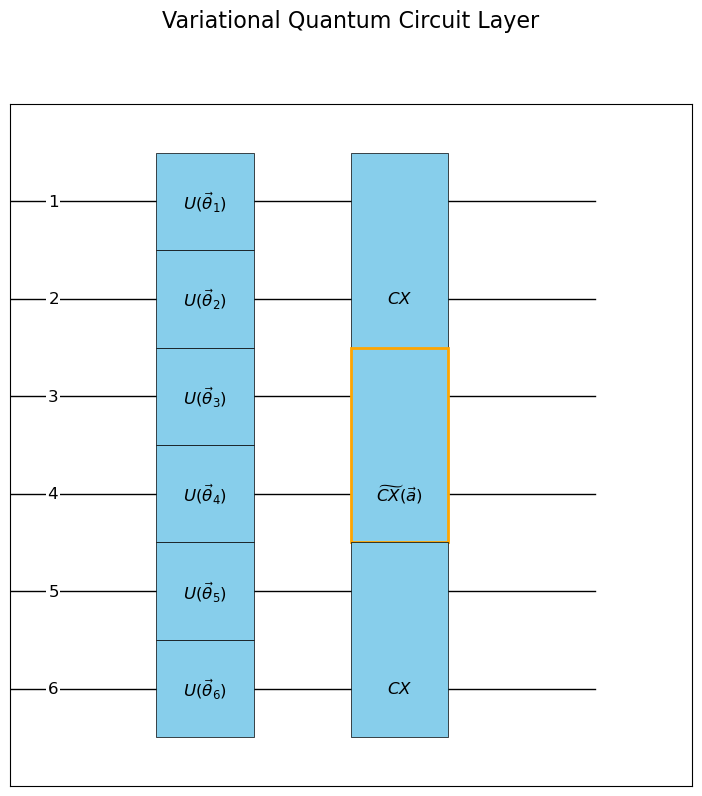

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pylatexenc
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer

# Constants for drawing
BOX_WIDTH = 1
BOX_HEIGHT = 2  # Double the height for CX
WIRE_SPACING = 1
FONT_SIZE = 12
GAMMA_OFFSET = 0.3


def draw_circuit():
    """Draws the quantum circuit based on the given image."""

    num_qubits = 6
    qc = QuantumCircuit(num_qubits)  # Initialize Quantum Circuit

    fig, ax = plt.subplots(figsize=(10, 8))

    # Set axis limits and remove ticks
    ax.set_xlim(-1, 6)
    ax.set_ylim(-1, num_qubits)  # Original limits
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])

    # Draw horizontal lines (qubit wires)
    for i in range(num_qubits):
        ax.plot([-1, 5], [num_qubits - 1 - i, num_qubits - 1 - i], "k-", linewidth=1)

    # Add qubit labels (Numbers 1-6)
    qubit_labels = [str(i + 1) for i in range(num_qubits)]  # Names of qubits
    for i, label in enumerate(qubit_labels):
        ax.text(
            -0.5,
            num_qubits - 1 - i,
            f"${label}$",
            ha="right",
            va="center",
            fontsize=FONT_SIZE,
            bbox=dict(facecolor="white", edgecolor="none", pad=1),
        )  # White box

    # Draw U gates with updated indices
    for i in range(num_qubits):
        x_pos = 1  # X position of gates.
        box = plt.Rectangle(
            (
                x_pos - BOX_WIDTH / 2,
                num_qubits - 1 - i - 0.5,
            ),  # Centered properly with BOX_HEIGHT=1
            BOX_WIDTH,
            1,  # Height =1 for these boxes
            facecolor="skyblue",
            edgecolor="black",
            linewidth=0.5,
            zorder=2,
        )
        ax.add_patch(box)
        ax.text(
            x_pos,
            num_qubits - 1 - i,
            f"$U({{\\vec{{\\theta}}_{i+1}}})$",
            ha="center",
            va="center",
            fontsize=FONT_SIZE,
        )

    # CX gates (shifted down)
    cx_positions = [1, 3, 5]  # Positions of the *top* qubits for CX gates
    x_pos = 3
    for i in range(len(cx_positions)):  # Each gate now takes two qubits
        if i == 0 or i == 2:
            box = plt.Rectangle(
                (
                    x_pos - BOX_WIDTH / 2,
                    num_qubits - 2 - cx_positions[i] + 0.5,
                ),  # Shifted Down
                BOX_WIDTH,
                2,
                facecolor="skyblue",
                edgecolor="black",
                linewidth=0.5,
                zorder=2,
            )
            ax.add_patch(box)
            ax.text(
                x_pos,
                num_qubits - 1 - cx_positions[i],
                "$CX$",
                ha="center",
                va="center",
                fontsize=FONT_SIZE,
            )
        else:
            # Tilde CX(a) gate
            box_a = plt.Rectangle(
                (
                    x_pos - BOX_WIDTH / 2,
                    num_qubits - 2 - cx_positions[i] + 0.5,
                ),  # Shifted Down
                BOX_WIDTH,
                2,
                facecolor="skyblue",
                edgecolor="orange",
                linewidth=2,
                zorder=2,
            )
            ax.add_patch(box_a)
            ax.text(
                x_pos,
                num_qubits - 1 - cx_positions[i],
                "$\\widetilde{CX}(\\vec{a})$",
                ha="center",
                va="center",
                fontsize=FONT_SIZE,
            )

    # # Draw Gamma arrows
    # start_gate_positions = [0, 1, 2, 3, 4]  # Index of the gates from where the gammas come
    # gamma_offsets = [0.5, 0.5, 0.6, 0.6, 0.5]
    # for i in range(len(start_gate_positions)):
    #     #  Adjust the arrows with an offset to display the interaction between lines
    #     gamma_start = (1 + gamma_offsets[i] * ((-1) ** i) * 0.05, num_qubits - 1 - start_gate_positions[i])  # Gate position (before)
    #     gamma_end = (1 + gamma_offsets[i] * ((-1) ** i) * 0.05, num_qubits - 2 - start_gate_positions[i])  # Go to next qubit
    #     if i == 0:
    #         gamma_name = "$\\gamma_{0 \\rightarrow 1}$"
    #         arrow_midpoint = (
    #             gamma_start[0],
    #             (gamma_start[1] + gamma_end[1]) / 2 - 0.1,
    #         )  # Move label to the arrow mid point
    #         ax.annotate(
    #             gamma_name,
    #             xy=gamma_end,
    #             xytext=arrow_midpoint,
    #             arrowprops=dict(arrowstyle="->", color="red", connectionstyle="arc3,rad=0.2"),
    #             fontsize=10,
    #             ha="center",
    #             va="bottom",
    #             xycoords="data",
    #             textcoords="data",
    #         )
    #     elif i == 1:
    #         gamma_name = "$\\gamma_{1 \\rightarrow 2}$"
    #         arrow_midpoint = (
    #             gamma_start[0],
    #             (gamma_start[1] + gamma_end[1]) / 2 - 0.1,
    #         )  # Move label to the arrow mid point
    #         ax.annotate(
    #             gamma_name,
    #             xy=gamma_end,
    #             xytext=arrow_midpoint,
    #             arrowprops=dict(arrowstyle="->", color="red", connectionstyle="arc3,rad=0.2"),
    #             fontsize=10,
    #             ha="center",
    #             va="bottom",
    #             xycoords="data",
    #             textcoords="data",
    #         )
    #     elif i == 2:
    #         # Split in two gammas
    #         # First gamma
    #         gamma_name = "$\\gamma_{2 \\rightarrow 3}$"
    #         arrow_midpoint = (
    #             gamma_start[0],
    #             (gamma_start[1] + gamma_end[1]) / 2 - 0.1,
    #         )  # Move label to the arrow mid point
    #         ax.annotate(
    #             gamma_name,
    #             xy=gamma_end,
    #             xytext=arrow_midpoint,
    #             arrowprops=dict(arrowstyle="->", color="red", connectionstyle="arc3,rad=0.2"),
    #             fontsize=10,
    #             ha="center",
    #             va="bottom",
    #             xycoords="data",
    #             textcoords="data",
    #         )
    #         # Second gamma
    #         gamma_name = "$\\gamma_{3 \\leftarrow 2}$"
    #         arrow_midpoint = (
    #             gamma_start[0],
    #             (gamma_start[1] + gamma_end[1]) / 2 - 0.1,
    #         )  # Move label to the arrow mid point
    #
    #         gamma_start = (1 + gamma_offsets[i] * ((-1) ** i) * 0.05, num_qubits - 1 - start_gate_positions[i])  # Gate position (before)
    #         gamma_end = (1 + gamma_offsets[i] * ((-1) ** i) * 0.05, num_qubits - 0 - start_gate_positions[i])  # Go to previous qubit
    #
    #         ax.annotate(
    #             gamma_name,
    #             xy=gamma_end,
    #             xytext=arrow_midpoint,
    #             arrowprops=dict(arrowstyle="->", color="red", connectionstyle="arc3,rad=-0.2"),
    #             fontsize=10,
    #             ha="center",
    #             va="top",
    #             xycoords="data",
    #             textcoords="data",
    #         )
    #     elif i == 3:
    #         gamma_name = "$\\gamma_{4 \\leftarrow 3}$"
    #         arrow_midpoint = (
    #             gamma_start[0],
    #             (gamma_start[1] + gamma_end[1]) / 2 - 0.1,
    #         )  # Move label to the arrow mid point
    #
    #         ax.annotate(
    #             gamma_name,
    #             xy=gamma_end,
    #             xytext=arrow_midpoint,
    #             arrowprops=dict(arrowstyle="->", color="red", connectionstyle="arc3,rad=-0.2"),
    #             fontsize=10,
    #             ha="center",
    #             va="top",
    #             xycoords="data",
    #             textcoords="data",
    #         )
    #     elif i == 4:
    #         gamma_name = "$\\gamma_{5 \\rightarrow 4}$"
    #         arrow_midpoint = (
    #             gamma_start[0],
    #             (gamma_start[1] + gamma_end[1]) / 2 - 0.1,
    #         )  # Move label to the arrow mid point
    #         ax.annotate(
    #             gamma_name,
    #             xy=gamma_end,
    #             xytext=arrow_midpoint,
    #             arrowprops=dict(arrowstyle="->", color="red", connectionstyle="arc3,rad=0.2"),
    #             fontsize=10,
    #             ha="center",
    #             va="bottom",
    #             xycoords="data",
    #             textcoords="data",
    #         )

    plt.title(
        "Variational Quantum Circuit Layer", fontsize=16, y=1.1
    )  # Adjusted title position
    plt.tight_layout()

    return fig


# Draw the circuit and show it.
fig = draw_circuit()
plt.show()

In [ ]:
from rl_qoc import StateTarget
from qiskit.quantum_info import Statevector
import numpy as np

state = 1 / np.sqrt(2) * (Statevector.from_label("00") + Statevector.from_label("11"))
state.draw("latex")

<IPython.core.display.Latex object>

In [ ]:
state = StateTarget(state)

In [ ]:
state.Chi

array([ 0.5,  0. ,  0. ,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. , -0.5,
        0. ,  0. ,  0. ,  0. ,  0.5])